# BANK REVIEWS ANALYSIS

## Problem Statement

### Central banks collecting information about customer satisfaction with the services provided by different bank. Also collects the information about the complaints.
### • Bank users give ratings and write reviews about services on central bank websites. These reviews and ratings help to banks evaluate services provided and take necessary to action improve customer service. While ratings are useful to convey the overall experience, they do not convey the context which led a reviewer to that experience.
### • If we look at only the rating, it is difficult to guess why the user rated the service as 4 stars. However, after reading the review, it is not difficult to identify that the review talks about good "service" and “expectations’


### The objective of this project is to analyze customer reviews and predict customer satisfaction with the reviews
#### • Data processing
#### • Key positive words/negative words (most frequent words)
#### • Classification of reviews into positive, negative and neutral
#### • Identify key themes of problems (using clustering, topic models)
#### • Predicting star ratings using reviews
#### • Perform intent analysis


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import nltk
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
bank=pd.read_excel('BankReviews.xlsx')

In [3]:
bank.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


## EDA

In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [5]:
bank.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

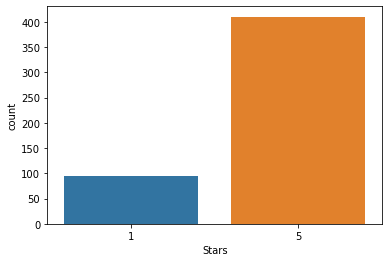

In [6]:
sns.countplot('Stars',data=bank)
plt.show()

In [7]:
bank.isna().sum()

Date        0
Stars       0
Reviews     0
BankName    0
dtype: int64

In [8]:
#Removing unwanted symbols and numbers from the reviews and performing case standardization
def remove_punctutions(x):
    x=re.sub('[^a-zA-Z ]','',x)
    x=re.sub('[0-9]',"",x)
    x=re.sub('xD','',x)
    x=x.strip()
    return x.lower()

In [9]:
bank['reviews_clean']=bank['Reviews'].apply(lambda x: remove_punctutions(x))

In [10]:
#finding polarity of the reviews
def polarity(review):
    temp=TextBlob(review)
    return temp.polarity

In [11]:
bank['polarity']=bank['reviews_clean'].apply(lambda x : polarity(x))

In [12]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000


In [13]:
def polarity_cat(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity == 0:
        return 'Neutral'
    else:
        return 'Negative' 

In [14]:
bank['polarity_cat']=bank['polarity'].apply(lambda x : polarity_cat(x))

In [15]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive


In [16]:
bank.polarity_cat.value_counts()

Positive    467
Negative     34
Neutral       4
Name: polarity_cat, dtype: int64

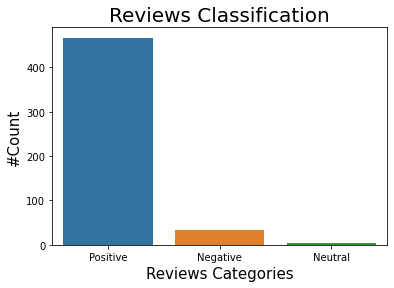

In [17]:
sns.countplot('polarity_cat',data=bank,orient='v')
plt.title('Reviews Classification',fontsize=20)
plt.xlabel('Reviews Categories',fontsize=15)
plt.ylabel('#Count',fontsize=15)
plt.show()

In [18]:
pos_rev=bank.reviews_clean[bank.polarity_cat=='Positive']

In [19]:
pos_rev

0      great job wyndham capital each person was prof...
1      matthew richardson is professional and helpful...
3      we have been dealing with brad thomka from the...
4      i cant express how grateful i am for the suppo...
5      i had the pleasure of working with wyndham cap...
                             ...                        
500    i never write reviews but had to this time to ...
501    it all started when bob g ran a credit check w...
502    what a horrible experience we have excellent c...
503    rep was extremely professional friendly and he...
504    i was working with a loan consultant from nasb...
Name: reviews_clean, Length: 467, dtype: object

In [20]:
neg_rev=bank.reviews_clean[bank.polarity_cat=='Negative']

In [21]:
neg_rev.head()

2     we had a past experience with wyndham mortgage...
17    this was the worst experience ever it was like...
39    the closing process for a va loan went smoothl...
40    miserable experience they screwed up everythin...
44    this lender contacted my previous phone number...
Name: reviews_clean, dtype: object

In [22]:
#Combining all positive and negative review for Wordcloud
def combine_text_function(x):
    combine_text=''
    for i in x:
        combine_text+=i
    return combine_text

In [23]:
pos_rev_comb=combine_text_function(pos_rev)

In [24]:
neg_rev_comb=combine_text_function(neg_rev)

In [25]:
w_pos=WordCloud(max_font_size=80, max_words=100,background_color="white").generate(pos_rev_comb)
w_neg=WordCloud(max_font_size=80, max_words=100,background_color="white").generate(neg_rev_comb)

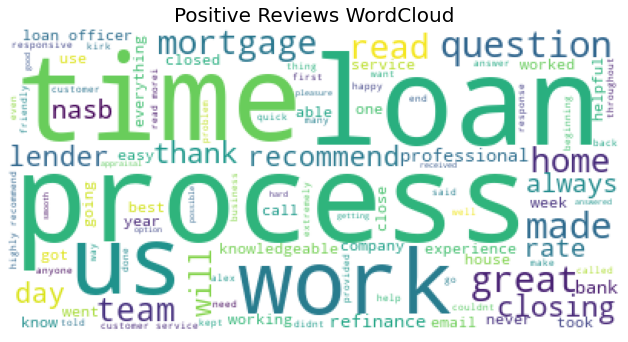

In [26]:
plt.figure(figsize=(11,9))
plt.imshow(w_pos)
plt.title('Positive Reviews WordCloud',fontsize=20)
plt.axis("off")
plt.show()

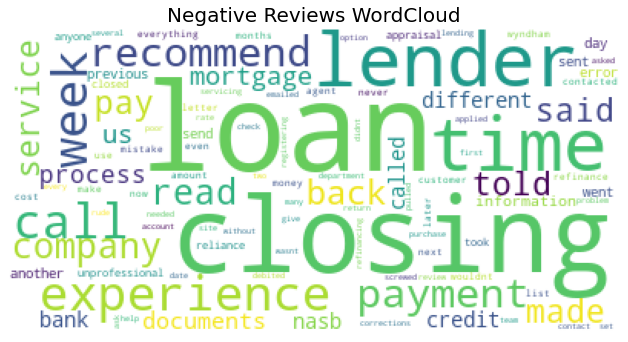

In [27]:
plt.figure(figsize=(11,9))
plt.imshow(w_neg)
plt.title('Negative Reviews WordCloud',fontsize=20)
plt.axis("off")
plt.show()

# Text Cleaning

In [28]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive


In [29]:
(bank.polarity_cat[bank.Stars==1]).value_counts()

Positive    63
Negative    28
Neutral      4
Name: polarity_cat, dtype: int64

### Tokenization

In [30]:
def token(word):
    return word.split(' ')

In [31]:
bank['reviews_token']=bank['reviews_clean'].apply(lambda x : token(x))

In [32]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat,reviews_token
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive,"[great, job, wyndham, capital, each, person, w..."
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, is, professional, and, h..."
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative,"[we, had, a, past, experience, with, wyndham, ..."
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive,"[we, have, been, dealing, with, brad, thomka, ..."
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive,"[i, cant, express, how, grateful, i, am, for, ..."


### Typo Corrections

In [33]:
def typo(text):
    typo_list=[]
    for word in text:
        tb=TextBlob(word)
        typo_list.append(tb.correct().raw)
    return typo_list

In [34]:
bank['reviews_typo']=bank['reviews_token'].apply(lambda x : typo(x))

In [35]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat,reviews_token,reviews_typo
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive,"[great, job, wyndham, capital, each, person, w...","[great, job, wyndham, capital, each, person, w..."
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, is, professional, and, h...","[matthew, richardson, is, professional, and, h..."
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative,"[we, had, a, past, experience, with, wyndham, ...","[we, had, a, past, experience, with, wyndham, ..."
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive,"[we, have, been, dealing, with, brad, thomka, ...","[we, have, been, dealing, with, bad, thomas, f..."
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive,"[i, cant, express, how, grateful, i, am, for, ...","[i, can, express, how, grateful, i, am, for, t..."


### Removing Stopwords

In [36]:
list_stopwords=stopwords.words('english')

In [37]:
len(list_stopwords)

179

In [38]:
def rem_stopwords(x):
    for i in x:
        if i in list_stopwords:
            x.remove(i)
    return x

In [39]:
bank['reviews_stopwords']=bank['reviews_typo'].apply(lambda x : rem_stopwords(x))

In [40]:
bank.reviews_stopwords

0      [great, job, wyndham, capital, person, profess...
1      [matthew, richardson, professional, helpful, h...
2      [had, past, experience, wyndham, mortgage, wou...
3      [have, dealing, bad, thomas, beginning, what, ...
4      [can, express, grateful, am, support, each, pr...
                             ...                        
500    [never, write, reviews, time, prevent, anyone,...
501    [all, started, bob, g, ran, credit, check, wit...
502    [horrible, experience, have, excellent, credit...
503    [rep, extremely, professional, friendly, helpf...
504    [working, loan, consultant, naso, told, would,...
Name: reviews_stopwords, Length: 505, dtype: object

### Stemming and Lemmatization

#### Stemming

In [41]:
ps=nltk.stem.PorterStemmer()

In [42]:
def stem(text):
    temp_stem=[]
    for word in text:
        temp_stem.append(ps.stem(word))
    return temp_stem

In [43]:
bank['reviews_stem']=bank['reviews_stopwords'].apply(lambda x : stem(x))

#### Lemmatization

In [44]:
wn=nltk.wordnet.WordNetLemmatizer()

In [45]:
def lemma(text):
    temp_lemma=[]
    for word in text:
        temp_lemma.append(wn.lemmatize(word))
    return temp_lemma

In [46]:
bank['reviews_stem_lemma']=bank['reviews_stem'].apply(lambda x : lemma(x))

In [47]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat,reviews_token,reviews_typo,reviews_stopwords,reviews_stem,reviews_stem_lemma
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive,"[great, job, wyndham, capital, each, person, w...","[great, job, wyndham, capital, person, profess...","[great, job, wyndham, capital, person, profess...","[great, job, wyndham, capit, person, professio...","[great, job, wyndham, capit, person, professio..."
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, is, professional, and, h...","[matthew, richardson, professional, helpful, h...","[matthew, richardson, professional, helpful, h...","[matthew, richardson, profession, help, help, ...","[matthew, richardson, profession, help, help, ..."
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative,"[we, had, a, past, experience, with, wyndham, ...","[had, past, experience, wyndham, mortgage, wou...","[had, past, experience, wyndham, mortgage, wou...","[had, past, experi, wyndham, mortgag, would, w...","[had, past, experi, wyndham, mortgag, would, w..."
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive,"[we, have, been, dealing, with, brad, thomka, ...","[have, dealing, bad, thomas, beginning, what, ...","[have, dealing, bad, thomas, beginning, what, ...","[have, deal, bad, thoma, begin, what, start, d...","[have, deal, bad, thoma, begin, what, start, d..."
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive,"[i, cant, express, how, grateful, i, am, for, ...","[can, express, grateful, am, support, each, pr...","[can, express, grateful, am, support, each, pr...","[can, express, grate, am, support, each, provi...","[can, express, grate, am, support, each, provi..."


## Final Cleaned Reviews

In [48]:
def cleaned(text):
    return ' '.join(text)

In [49]:
bank['reviews_cleaned_final']=bank['reviews_stem_lemma'].apply(lambda x : cleaned(x))

In [50]:
bank.head()

,Date,Stars,Reviews,BankName,reviews_clean,polarity,polarity_cat,reviews_token,reviews_typo,reviews_stopwords,reviews_stem,reviews_stem_lemma,reviews_cleaned_final
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage,great job wyndham capital each person was prof...,0.433333,Positive,"[great, job, wyndham, capital, each, person, w...","[great, job, wyndham, capital, person, profess...","[great, job, wyndham, capital, person, profess...","[great, job, wyndham, capit, person, professio...","[great, job, wyndham, capit, person, professio...",great job wyndham capit person profession help...
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage,matthew richardson is professional and helpful...,0.453333,Positive,"[matthew, richardson, is, professional, and, h...","[matthew, richardson, professional, helpful, h...","[matthew, richardson, professional, helpful, h...","[matthew, richardson, profession, help, help, ...","[matthew, richardson, profession, help, help, ...",matthew richardson profession help help u find...
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage,we had a past experience with wyndham mortgage...,-0.030106,Negative,"[we, had, a, past, experience, with, wyndham, ...","[had, past, experience, wyndham, mortgage, wou...","[had, past, experience, wyndham, mortgage, wou...","[had, past, experi, wyndham, mortgag, would, w...","[had, past, experi, wyndham, mortgag, would, w...",had past experi wyndham mortgag would without ...
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage,we have been dealing with brad thomka from the...,0.067698,Positive,"[we, have, been, dealing, with, brad, thomka, ...","[have, dealing, bad, thomas, beginning, what, ...","[have, dealing, bad, thomas, beginning, what, ...","[have, deal, bad, thoma, begin, what, start, d...","[have, deal, bad, thoma, begin, what, start, d...",have deal bad thoma begin what start distress ...
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage,i cant express how grateful i am for the suppo...,0.115000,Positive,"[i, cant, express, how, grateful, i, am, for, ...","[can, express, grateful, am, support, each, pr...","[can, express, grateful, am, support, each, pr...","[can, express, grate, am, support, each, provi...","[can, express, grate, am, support, each, provi...",can express grate am support each provid my fa...


# Creating DTM (Count Vectorizer)

In [51]:
count_vect=CountVectorizer(stop_words='english',ngram_range=(1,2))

In [52]:
dtm=count_vect.fit_transform(bank['reviews_cleaned_final'])

In [53]:
dtm=dtm.todense()

In [54]:
dtm_final=pd.DataFrame(data=dtm,columns=count_vect.get_feature_names())

In [55]:
dtm_final

,aaron,aaron anyon,aaron custom,aaron cut,aaron everyth,aaron extrem,aaron fought,aaron guarante,aaron howev,aaron look,...,year wa,year want,year work,yelp,yelp review,yep,yep paid,zero,zero option,zero point
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Classification of Reviews into Positive, Negative and Neutral

In [56]:
#Positive ---> 2
#Neutral ----> 1
#Negative ----> 0
def flag(df):
    if df=='Positive':
        return 2
    elif df=='Neutral':
        return 1
    else: 
        return 0

In [57]:
dtm_final['target_y']=bank['polarity_cat'].apply(lambda x:flag(x))

In [58]:
dtm_final['target_y'].value_counts()

2    467
0     34
1      4
Name: target_y, dtype: int64

In [59]:
X=dtm_final.drop(columns=['target_y'])
Y=dtm_final['target_y']

In [60]:
X.shape

(505, 10952)

In [61]:
Y.shape

(505,)

## Train Test Split

In [62]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=101)

In [63]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(353, 10952)
(353,)
(152, 10952)
(152,)


# Model Building

### Naive Bayes

In [64]:
mnb=MultinomialNB()

In [65]:
mnb=mnb.fit(X_train,Y_train)

In [66]:
mnb_train_pred=mnb.predict(X_train)

In [67]:
mnb_test_pred=mnb.predict(X_test)

#### Train Performace Metrics

In [68]:
print('Accuracy Score of Train for Naive Bayes Model : ',accuracy_score(Y_train,mnb_train_pred))
print('\n============================================================\n')
print('Confusion Matrix of Train for Naive Bayes Model : \n',confusion_matrix(Y_train,mnb_train_pred))
print('\n============================================================\n')
print('Classification Report of Train for Naive Bayes Model : \n\n',classification_report(Y_train,mnb_train_pred))

Accuracy Score of Train for Naive Bayes Model :  0.9915014164305949


Confusion Matrix of Train for Naive Bayes Model : 
 [[ 22   0   2]
 [  0   2   1]
 [  0   0 326]]


Classification Report of Train for Naive Bayes Model : 

               precision    recall  f1-score   support

           0       1.00      0.92      0.96        24
           1       1.00      0.67      0.80         3
           2       0.99      1.00      1.00       326

    accuracy                           0.99       353
   macro avg       1.00      0.86      0.92       353
weighted avg       0.99      0.99      0.99       353



#### Test Performace Metrics

In [69]:
print('Accuracy Score of Test for Naive Bayes Model : ',accuracy_score(Y_test,mnb_test_pred))
print('\n============================================================\n')
print('Confusion Matrix of Test for Naive Bayes Model : \n',confusion_matrix(Y_test,mnb_test_pred))
print('\n============================================================\n')
print('Classification Report of Test for Naive Bayes Model : \n\n',classification_report(Y_test,mnb_test_pred))

Accuracy Score of Test for Naive Bayes Model :  0.875


Confusion Matrix of Test for Naive Bayes Model : 
 [[  2   0   8]
 [  0   0   1]
 [ 10   0 131]]


Classification Report of Test for Naive Bayes Model : 

               precision    recall  f1-score   support

           0       0.17      0.20      0.18        10
           1       0.00      0.00      0.00         1
           2       0.94      0.93      0.93       141

    accuracy                           0.88       152
   macro avg       0.37      0.38      0.37       152
weighted avg       0.88      0.88      0.88       152



### RandomForest Classifier

In [70]:
rfc=RandomForestClassifier()

In [71]:
rfc=rfc.fit(X_train,Y_train)

In [72]:
rfc_train_pred=rfc.predict(X_train)

In [73]:
rfc_test_pred=rfc.predict(X_test)

#### Train Performace Metrics

In [74]:
print('Accuracy Score of Train for Random Forest Classifier Model : ',accuracy_score(Y_train,rfc_train_pred))
print('\n============================================================\n')
print('Confusion Matrix of Train for Random Forest Classifier Model : \n',confusion_matrix(Y_train,rfc_train_pred))
print('\n============================================================\n')
print('Classification Report of Train for Random Forest Classifier Model : \n\n',classification_report(Y_train,rfc_train_pred))

Accuracy Score of Train for Random Forest Classifier Model :  1.0


Confusion Matrix of Train for Random Forest Classifier Model : 
 [[ 24   0   0]
 [  0   3   0]
 [  0   0 326]]


Classification Report of Train for Random Forest Classifier Model : 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00       326

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



#### Test Performace Metrics

In [75]:
print('Accuracy Score of Test for Random Forest Classifier Model : ',accuracy_score(Y_test,rfc_test_pred))
print('\n============================================================\n')
print('Confusion Matrix of Test for Random Forest Classifier Model : \n',confusion_matrix(Y_test,rfc_test_pred))
print('\n============================================================\n')
print('Classification Report of Test for Random Forest Classifier Model : \n\n',classification_report(Y_test,rfc_test_pred))

Accuracy Score of Test for Random Forest Classifier Model :  0.9210526315789473


Confusion Matrix of Test for Random Forest Classifier Model : 
 [[  1   0   9]
 [  0   0   1]
 [  2   0 139]]


Classification Report of Test for Random Forest Classifier Model : 

               precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.00      0.00      0.00         1
           2       0.93      0.99      0.96       141

    accuracy                           0.92       152
   macro avg       0.42      0.36      0.37       152
weighted avg       0.89      0.92      0.90       152



### ANN Classifier

In [76]:
mlp=MLPClassifier()

In [77]:
mlp=mlp.fit(X_train,Y_train)

In [78]:
mlp_train_pred=mlp.predict(X_train)

In [79]:
mlp_test_pred=mlp.predict(X_test)

#### Train Performace Metrics

In [80]:
print('Accuracy Score of Train for ANN Classifier Model : ',accuracy_score(Y_train,mlp_train_pred))
print('\n============================================================\n')
print('Confusion Matrix of Train for ANN Classifier Model : \n',confusion_matrix(Y_train,mlp_train_pred))
print('\n============================================================\n')
print('Classification Report of Train for ANN Classifier Model : \n\n',classification_report(Y_train,mlp_train_pred))

Accuracy Score of Train for ANN Classifier Model :  1.0


Confusion Matrix of Train for ANN Classifier Model : 
 [[ 24   0   0]
 [  0   3   0]
 [  0   0 326]]


Classification Report of Train for ANN Classifier Model : 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00       326

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



#### Test Performace Metrics

In [81]:
print('Accuracy Score of Test for ANN Classifier Model : ',accuracy_score(Y_test,mlp_test_pred))
print('\n============================================================\n')
print('Confusion Matrix of Test for ANN Classifier Model : \n',confusion_matrix(Y_test,mlp_test_pred))
print('\n============================================================\n')
print('Classification Report of Test for ANN Classifier Model : \n\n',classification_report(Y_test,mlp_test_pred))

Accuracy Score of Test for ANN Classifier Model :  0.9210526315789473


Confusion Matrix of Test for ANN Classifier Model : 
 [[  1   0   9]
 [  0   0   1]
 [  2   0 139]]


Classification Report of Test for ANN Classifier Model : 

               precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.00      0.00      0.00         1
           2       0.93      0.99      0.96       141

    accuracy                           0.92       152
   macro avg       0.42      0.36      0.37       152
weighted avg       0.89      0.92      0.90       152



## Inference:
### Both Random Forest Classifier and ANN Classifier (Multilayer Perceptron) doing good in predicting the customer reviews into Positive (2), Negative (0) and Neutral (1)

# Topic Modelling

In [82]:
km=KMeans(n_clusters=5)

In [83]:
km=km.fit(X)

In [84]:
km.inertia_

36145.210020876824

### Finding Best Value of K

In [85]:
cluster_error=[]
for cluster in [1,2,3,4,5,6]:
    km=KMeans(n_clusters=cluster)
    km=km.fit(X)
    cluster_error.append(km.inertia_) 

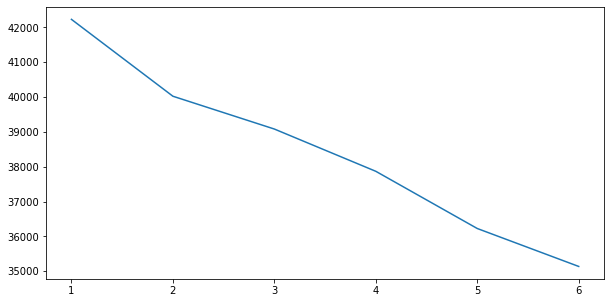

In [86]:
plt.figure(figsize=(10,5))
sns.lineplot(x=np.array(range(1,7)),y=np.array(cluster_error))
plt.show()

In [87]:
sc_score=[]
for i in [2,3,4,5,6]:
    km=KMeans(n_clusters=i)
    km=km.fit(X)
    sc_score.append(silhouette_score(X,km.labels_))

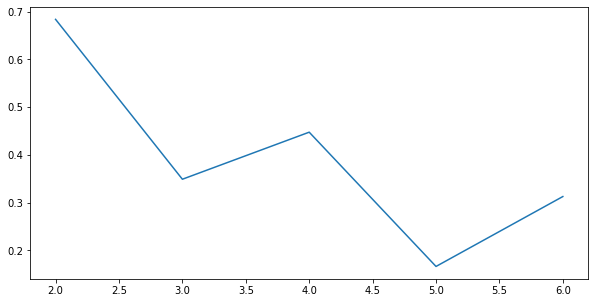

In [88]:
plt.figure(figsize=(10,5))
sns.lineplot(x=np.array(range(2,7)),y=np.array(sc_score))
plt.show()

### Inference--> From above two test we can conclude that k=2 is the best value of K for our data.

In [89]:
kmean=KMeans(n_clusters=3)

In [90]:
kmean=kmean.fit(X)

In [91]:
kmean.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [92]:
kmean.cluster_centers_

array([[6.93889390e-18, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.63709677e-02, 4.03225806e-03, 4.03225806e-03, ...,
        4.03225806e-03, 2.01612903e-03, 2.01612903e-03]])

### K Means is found out to be not working as good as expected, Let's try LDA

In [93]:
lda=LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=50)
lda=lda.fit(X)

In [94]:
pd.DataFrame(data=lda.components_,columns=X.columns).T

,0,1,2,3,4,5,6,7,8,9
aaron,0.100032,0.100053,0.100034,3.106198,0.100038,6.262135,0.100038,4.805454,0.100155,9.999176
aaron anyon,0.100032,0.100029,0.100027,0.100032,0.100038,0.100029,0.100032,0.100126,0.100049,2.155225
aaron custom,0.100030,0.100030,0.100037,0.100036,0.100032,0.100028,0.100038,0.100131,0.100046,2.155216
aaron cut,0.100039,0.100037,0.100032,0.100028,0.100035,1.180983,0.100026,0.100114,0.100035,0.100035
aaron everyth,0.100034,0.100033,0.100027,0.100032,0.100034,2.155316,0.100032,0.100037,0.100029,0.100047
...,...,...,...,...,...,...,...,...,...,...
yep,0.100038,0.100033,0.100034,0.100027,0.100027,0.100041,0.100035,1.051171,0.100030,0.100036
yep paid,0.100032,0.100036,0.100026,0.100034,0.100036,0.100033,0.100031,1.051181,0.100040,0.100032
zero,0.100031,0.100051,0.100036,0.100031,0.100030,2.002307,0.100032,0.100033,0.100036,0.100032
zero option,0.100031,0.100033,0.100030,0.100035,0.100032,1.051182,0.100038,0.100033,0.100034,0.100032


In [95]:
terms=pd.Series(X.columns)

In [96]:
terms

0                aaron
1          aaron anyon
2         aaron custom
3            aaron cut
4        aaron everyth
             ...      
10947              yep
10948         yep paid
10949             zero
10950      zero option
10951       zero point
Length: 10952, dtype: object

In [97]:
temp=(lda.components_)[0].argsort()[:20]

In [98]:
terms.iloc[temp.tolist()].values

array(['firm talk', 'despit le', 'presenc', 'knew understood',
       'thank dean', 'accept person', 'guy begin', 'everyon wa',
       'benefici loan', 'said day', 'messag remain', 'recommend sam',
       'spoke broker', 'time frame', 'capit seven', 'rascal extrem',
       'hard sale', 'longer', 'commun realli', 'ask send'], dtype=object)

In [99]:
for i in range(0,10):
    topic_words=(lda.components_)[i].argsort()[:30]
    words=terms.iloc[topic_words.tolist()].values
    print("Topic "+str(i+1)+' words are : ',','.join(words))
    print('\n')
    

Topic 1 words are :  firm talk,despit le,presenc,knew understood,thank dean,accept person,guy begin,everyon wa,benefici loan,said day,messag remain,recommend sam,spoke broker,time frame,capit seven,rascal extrem,hard sale,longer,commun realli,ask send,differ compoentsfe,prompt approv,buy attitud,addressresolv,fred awesom,past far,deliv everyth,sign noth,kirk ask,kept deal


Topic 2 words are :  respond ani,chose home,wa mostli,woe,estim fact,compani help,opinion,knowledg exceed,help secur,implac read,worth believ,somebodi,process smooth,philip great,secur,close suggest,wa hous,sure happi,histori check,believ close,peter wa,process introduc,whi hire,chose work,june lee,vari,capit profession,home look,later wa,frequent reli


Topic 3 words are :  work great,self sale,deserv special,cost quit,fianc,come,forgot use,use compani,work penni,sure got,letter horribl,skill alway,sensit,level experienc,mani coordin,everi hour,cost titl,suitabl come,profession avail,disappoint,fast husband,email m

# Predicting Star Ratings

In [100]:
X

,aaron,aaron anyon,aaron custom,aaron cut,aaron everyth,aaron extrem,aaron fought,aaron guarante,aaron howev,aaron look,...,year wa,year want,year work,yelp,yelp review,yep,yep paid,zero,zero option,zero point
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
X_train_stars,X_test_stars,Y_train_stars,Y_test_stars=train_test_split(X,bank.Stars,test_size=0.3,random_state=101)

In [102]:
X_test_stars.shape

(152, 10952)

In [103]:
X_test_stars.shape

(152, 10952)

### Naive Bayes Classifier

In [104]:
bnb=BernoulliNB()

In [105]:
bnb=bnb.fit(X_train_stars,Y_train_stars)

In [106]:
bnb_train_pred_stars=bnb.predict(X_train_stars)

In [107]:
bnb_test_pred_stars=bnb.predict(X_test_stars)

#### Train Performace Metrics

In [108]:
print('Accuracy Score of Train for Naive Bayes Classifier Model : ',accuracy_score(Y_train_stars,bnb_train_pred_stars))
print('\n============================================================\n')
print('Confusion Matrix of Train for Naive Bayes Classifier Model : \n',confusion_matrix(Y_train_stars,bnb_train_pred_stars))
print('\n============================================================\n')
print('Classification Report of Train for Naive Bayes Classifier Model : \n\n',classification_report(Y_train_stars,bnb_train_pred_stars))

Accuracy Score of Train for Naive Bayes Classifier Model :  0.8923512747875354


Confusion Matrix of Train for Naive Bayes Classifier Model : 
 [[ 21  38]
 [  0 294]]


Classification Report of Train for Naive Bayes Classifier Model : 

               precision    recall  f1-score   support

           1       1.00      0.36      0.53        59
           5       0.89      1.00      0.94       294

    accuracy                           0.89       353
   macro avg       0.94      0.68      0.73       353
weighted avg       0.90      0.89      0.87       353



#### Test Performace Metrics

In [109]:
print('Accuracy Score of Test for Naive Bayes Classifier Model : ',accuracy_score(Y_test_stars,bnb_test_pred_stars))
print('\n============================================================\n')
print('Confusion Matrix of Test for Naive Bayes Classifier Model : \n',confusion_matrix(Y_test_stars,bnb_test_pred_stars))
print('\n============================================================\n')
print('Classification Report of Test for Naive Bayes Classifier Model : \n\n',classification_report(Y_test_stars,bnb_test_pred_stars))

Accuracy Score of Test for Naive Bayes Classifier Model :  0.8421052631578947


Confusion Matrix of Test for Naive Bayes Classifier Model : 
 [[ 14  22]
 [  2 114]]


Classification Report of Test for Naive Bayes Classifier Model : 

               precision    recall  f1-score   support

           1       0.88      0.39      0.54        36
           5       0.84      0.98      0.90       116

    accuracy                           0.84       152
   macro avg       0.86      0.69      0.72       152
weighted avg       0.85      0.84      0.82       152



### ANN Classifier

In [110]:
mlp=MLPClassifier()

In [111]:
mlp=mlp.fit(X_train_stars,Y_train_stars)

In [112]:
mlp_train_pred_stars=mlp.predict(X_train_stars)

In [113]:
mlp_test_pred_stars=mlp.predict(X_test_stars)

#### Train Performace Metrics

In [114]:
print('Accuracy Score of Train for ANN Classifier Model : ',accuracy_score(Y_train_stars,mlp_train_pred_stars))
print('\n============================================================\n')
print('Confusion Matrix of Train for ANN Classifier Model : \n',confusion_matrix(Y_train_stars,mlp_train_pred_stars))
print('\n============================================================\n')
print('Classification Report of Train for ANN Classifier Model : \n\n',classification_report(Y_train_stars,mlp_train_pred_stars))

Accuracy Score of Train for ANN Classifier Model :  1.0


Confusion Matrix of Train for ANN Classifier Model : 
 [[ 59   0]
 [  0 294]]


Classification Report of Train for ANN Classifier Model : 

               precision    recall  f1-score   support

           1       1.00      1.00      1.00        59
           5       1.00      1.00      1.00       294

    accuracy                           1.00       353
   macro avg       1.00      1.00      1.00       353
weighted avg       1.00      1.00      1.00       353



#### Test Performace Metrics

In [115]:
print('Accuracy Score of Test for ANN Classifier Model : ',accuracy_score(Y_test_stars,mlp_test_pred_stars))
print('\n============================================================\n')
print('Confusion Matrix of Test for ANN Classifier Model : \n',confusion_matrix(Y_test_stars,mlp_test_pred_stars))
print('\n============================================================\n')
print('Classification Report of Test for ANN Classifier Model : \n\n',classification_report(Y_test_stars,mlp_test_pred_stars))

Accuracy Score of Test for ANN Classifier Model :  0.8618421052631579


Confusion Matrix of Test for ANN Classifier Model : 
 [[ 15  21]
 [  0 116]]


Classification Report of Test for ANN Classifier Model : 

               precision    recall  f1-score   support

           1       1.00      0.42      0.59        36
           5       0.85      1.00      0.92       116

    accuracy                           0.86       152
   macro avg       0.92      0.71      0.75       152
weighted avg       0.88      0.86      0.84       152



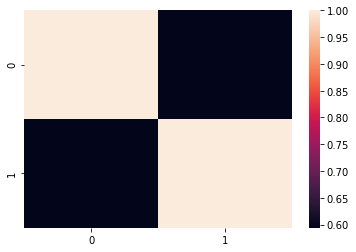

In [118]:
sns.heatmap(np.corrcoef(Y_test_stars,mlp_test_pred_stars))
plt.show()

## =====================HAPPY LEARNING====================